In [37]:
from data_prep_utils import *
from plot_prep_utils import *
import pandas as pd
import numpy as np

def apply_frequency_encoding(df, org_col_name, encoded_col_name):
    """
    Applies frequency encoding to a specified column in a DataFrame and stores the result in a new column.

    Parameters:
    - df : pandas.DataFrame, the DataFrame to be modified.
    - org_col_name : str, the name of the original column to apply frequency encoding to.
    - encoded_col_name : str, the name of the new column for storing the frequency encoded values.

    Returns:
    - pandas.DataFrame, the modified DataFrame with the new frequency encoded column added.
    """
    # Calculate frequencies
    frequency = df[org_col_name].value_counts(normalize=True)
    
    # Map frequencies back onto a new column in the DataFrame
    df[encoded_col_name] = df[org_col_name].map(frequency)
    
    return df

# Example usage:
# Assuming `df` is your DataFrame and 'Unified TX Categories' is the column you want to encode
# df = pd.read_csv('path_to_your_data.csv')  # Loading the DataFrame
# df_encoded = apply_frequency_encoding(df, 'Unified TX Categories', 'Unified_TX_Categories_Freq')
# print(df_encoded.head())

df_titan = pd.read_csv('TitanTop1288.csv')
df_eigenphi = pd.read_csv('EigenPhiTop200.csv')

# Ensure 'Unified TX Categories' is treated as string and trim spaces
df_titan['Unified TX Categories'] = df_titan['Unified TX Categories'].astype(str).str.strip()
df_eigenphi['Unified TX Categories'] = df_eigenphi['Unified TX Categories'].astype(str).str.strip()



# print(df_titan[df_titan["Unified TX Categories"]=="Sandwich"].head)

In [ ]:
## Generate block POS distribution for Titan and EigenPhi on TX Categories and TO
def calculate_blockPOS_summary(dimenion_col, df, csv_output):
    # Block POS Distribution: Pos 0-9, Pos 10-49, Pos>50
    df['Block_POS_Dist'] = df['Block POS'].apply(lambda x: 'Pos 0-9' if x <= 9 else ('Pos 10-49' if x <= 49 else 'Pos>50'))
    print(df['Block_POS_Dist'].value_counts())

    # Grouping by dimenion_col and 'Block_POS_Dist'
    grouped = df.groupby([dimenion_col, 'Block_POS_Dist'])

    # Calculating the sum of 'builder_reward' and count for each group
    # Using agg to apply different aggregation functions to the groupby object
    summary = grouped.agg(
        Count=('Block_POS_Dist', 'count'),  # Count occurrences
        Total_Builder_Reward=('builder_reward', 'sum')  # Sum of builder_reward
    ).unstack(fill_value=0)  # Unstack for better readability, filling missing values with 0

    # Print the resulting DataFrame
    print(summary)

    # If you want to flatten the MultiIndex columns after unstacking:
    summary.columns = [' '.join(col).strip() for col in summary.columns.values]
    print(summary)
    summary.to_csv(csv_output)

# Call the method with the desired DataFrame
calculate_blockPOS_summary('Unified TX Categories', df_titan, 'Titan_TX_Categories_Block_POS_Distribution.csv')
calculate_blockPOS_summary('to_label', df_titan, 'Titan_TO_Block_POS_Distribution.csv')
calculate_blockPOS_summary('Unified TX Categories', df_eigenphi, 'EigenPhi_TX_Categories_Block_POS_Distribution.csv')
calculate_blockPOS_summary('to_label', df_eigenphi, 'EigenPhi_TO_Block_POS_Distribution.csv')


In [42]:
## Generate Builder Payment Percentile Distribution and Summary for Titan and EigenPhi on TX Categories and TO
def calculate_BP_percentile_distribution_and_summary(dimension_col, df, csv_output):
    # Calculate the 10th, 25th, 50th, 75th, and 90th percentiles of 'builder_reward' for each group
    percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    percentiles_dict = df['builder_reward'].quantile(percentiles).to_dict()

    def categorize_reward(value, percentiles):
        if value <= percentiles[0.1]:
            return '0-10th Percentile'
        elif value <= percentiles[0.25]:
            return '10th-25th Percentile'
        elif value <= percentiles[0.5]:
            return '25th-50th Percentile'
        elif value <= percentiles[0.75]:
            return '50th-75th Percentile'
        elif value <= percentiles[0.9]:
            return '75th-90th Percentile'
        else:
            return 'Above 90th Percentile'

    # Apply categorization function
    df['Reward_Bracket'] = df['builder_reward'].apply(lambda x: categorize_reward(x, percentiles_dict))

    # Add a column to df to store the percentile group
    # Grouping by dimension_col
    grouped = df.groupby(dimension_col, 'Reward_Bracket')

    # Calculating the sum of 'builder_reward' for each group
    summary = grouped.agg(
        Count=('builder_reward', 'count'),  # Count occurrences
        Total_Builder_Reward=('builder_reward', 'sum'),  # Sum of builder_reward
        # **{f'{p*100}th Percentile': (lambda x, p=p: x.quantile(percentiles_dict[p])) for p in percentiles}  # Calculate percentiles
    )

        # Print the resulting DataFrame
    print(summary)

    # If you want to flatten the MultiIndex columns after unstacking:
    summary.columns = [' '.join(col).strip() for col in summary.columns.values]
    print(summary)
    summary.to_csv(csv_output)
    
calculate_BP_percentile_distribution_and_summary('Unified TX Categories', df_titan, 'Titan_TX_Categories_BP_Percentile_Distribution.csv')

ValueError: Bin labels must be one fewer than the number of bin edges

In [11]:
## Correlation between Tx Category and BP 
# Apply frequency encoding to 'Unified TX Categories' column
df_titan = apply_frequency_encoding(df_titan, 'Unified TX Categories', 'Tx_Category_Freq')
df_eigenphi = apply_frequency_encoding(df_eigenphi, 'Unified TX Categories', 'Tx_Category_Freq')


corr_value_titan = df_titan['Tx_Category_Freq'].corr(df_titan['Block POS'])
print(f"Titan: The correlation between 'Tx_Category_Freq' and 'Block POS' is: {corr_value_titan}")
corr_value_eigenphi = df_eigenphi['Tx_Category_Freq'].corr(df_eigenphi['Block POS'])
print(f"EigenPhi: The correlation between 'Tx_Category_Freq' and 'Block POS' is: {corr_value_eigenphi}")

Titan: The correlation between 'Tx_Category_Freq' and 'Block POS' is: -0.02307697116465857
EigenPhi: The correlation between 'Tx_Category_Freq' and 'Block POS' is: -0.2207295452832556


In [ ]:

def calc_corr_TXcounts_subtotalBP(group_df):
    correlation = group_df['Block POS'].corr(group_df['builder_reward'])
    count = len(group_df)  # 计算每个分类的行数
    return pd.Series({
    # 'Tx_Category': group_df['Unified TX Categories'].iloc[0],  # 由于是分组，所以每个组的第一个值就是该组的值
    'Correlation': correlation,
    'Count': count,  # 新增行数统计
    'Subtotal_Reawrd': group_df['builder_reward'].sum()  # 新增总和统计
})


def generate_correlations_counts_subtotalBP(group_column, csv_input, csv_output):
    df = pd.read_csv(csv_input)  # 替换为你的文件路径
    df = df.dropna(subset=['Block POS', 'builder_reward'])  # 删除这两列中含有 NaN 的行
    # 按 `Unified Tx Category` 分组，应用自定义函数：
    result = df.groupby(group_column).apply(calc_corr_TXcounts_subtotalBP)
    # Reset the index to ensure `group_column` remains as a column
    result = result.reset_index()
    result.to_csv(csv_output)
    print(result.columns)
    return result

titan_correl_on_TX_categories = generate_correlations_counts_subtotalBP('Unified TX Categories','TitanTop1288.csv', 'titan_correl_on_TX_categories.csv')
eigenphi_correl_on_TX_categories = generate_correlations_counts_subtotalBP('Unified TX Categories', 'EigenPhiTop200.csv', 'eigenphi_correl_on_TX_categories.csv')


titan_correl_on_to_label = generate_correlations_counts_subtotalBP('to_label','TitanTop1288.csv', 'titan_correl_on_TO.csv')
eigenphi_correl_on_to_label = generate_correlations_counts_subtotalBP('to_label', 'EigenPhiTop200.csv', 'eigenphi_correl_on_TO.csv') 


In [28]:


titan_labels = set(titan_correl_on_to_label['to_label'])
eigenphi_labels = set(eigenphi_correl_on_to_label['to_label'])

# Finding the intersection of the two sets of labels
shared_labels = titan_labels.intersection(eigenphi_labels)
print(len(shared_labels))


# Filter both DataFrames to only include rows with 'to_label' in shared_labels
df_titan_shared = titan_correl_on_to_label[titan_correl_on_to_label['to_label'].isin(shared_labels)]
df_eigenphi_shared = eigenphi_correl_on_to_label[eigenphi_correl_on_to_label['to_label'].isin(shared_labels)]
df_titan_shared.to_csv('titan_shared_labels.csv')
df_eigenphi_shared.to_csv('eigenphi_shared_labels.csv')

# # Merging the two DataFrames on 'to_label'
# # Renaming columns for clarity after merge
# columns_rename = {
#     'Correlation': 'Correlation_Titan',
#     'Count': 'Count_Titan',
#     'Subtotal_Reawrd': 'Subtotal_Reawrd_Titan'
# }
# df_titan_shared.rename(columns=columns_rename, inplace=True)

# columns_rename = {
#     'Correlation': 'Correlation_Eigenphi',
#     'Count': 'Count_Eigenphi',
#     'Subtotal_Reawrd': 'Subtotal_Reawrd_Eigenphi'
# }
# df_eigenphi_shared.rename(columns=columns_rename, inplace=True)

# # Merge on 'to_label'
# df_shared = pd.merge(df_titan_shared, df_eigenphi_shared, on='to_label', how='inner')

# # Print to see the merged DataFrame
# print(df_shared.head())

# Optionally save to CSV
# df_shared.to_csv('shared_labels_comparison.csv', index=False)

9


       Correlation       Count  Subtotal_Reawrd
count    17.000000   28.000000        28.000000
mean     -0.056972   46.000000        66.684781
std       0.476551  160.008565       164.392024
min      -0.853255    1.000000         0.641601
25%      -0.273670    1.000000         1.295949
50%      -0.039343    4.000000        14.352058
75%       0.065682   23.250000        43.737044
max       1.000000  852.000000       835.941103


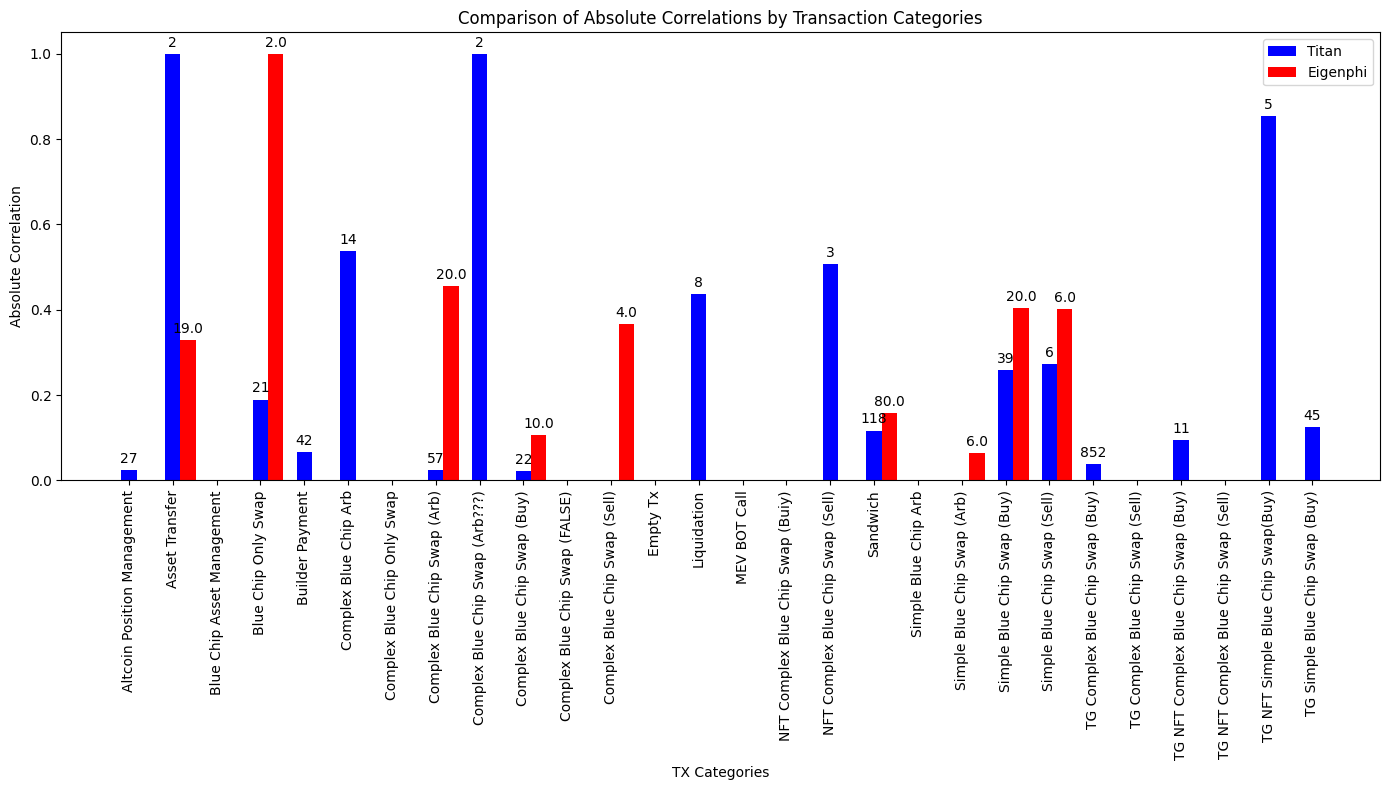

In [17]:
import matplotlib.pyplot as pl
# Set index for easier manipulation
print(titan_correl_on_TX_categories.describe())
titan_correl_on_TX_categories.set_index("Tx_Category", inplace=True)
eigenphi_correl_on_TX_categories.set_index("Tx_Category", inplace=True)

# Join datasets
df = titan_correl_on_TX_categories.join(eigenphi_correl_on_TX_categories, lsuffix='_titan', rsuffix='_eigenphi')

# Calculate absolute values of correlations for plotting
df['Abs_Correlation_titan'] = df['Correlation_titan'].abs()
df['Abs_Correlation_eigenphi'] = df['Correlation_eigenphi'].abs()

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
index = range(len(df))
bar_width = 0.35

# Create bars
rects1 = ax.bar(index, df['Abs_Correlation_titan'], bar_width, label='Titan',
                color='b', tick_label=df.index)
rects2 = ax.bar([p + bar_width for p in index], df['Abs_Correlation_eigenphi'],
                bar_width, label='Eigenphi', color='r')

# Add counts as labels
for rect, count in zip(rects1, df['Count_titan']):
    height = rect.get_height()
    ax.annotate('{}'.format(count),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for rect, count in zip(rects2, df['Count_eigenphi']):
    height = rect.get_height()
    ax.annotate('{}'.format(count),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Add features to the plot
ax.set_xlabel('TX Categories')
ax.set_ylabel('Absolute Correlation')
ax.set_title('Comparison of Absolute Correlations by Transaction Categories')
ax.legend()

# Rotate category labels for better readability
plt.xticks(rotation=90)
plt.tight_layout()  # To not cut off labels

# Show the plot
plt.show()

